Epoch 1/50, Loss: 0.1331
Epoch 2/50, Loss: 0.0579
Epoch 3/50, Loss: 0.0413
Epoch 4/50, Loss: 0.0386
Epoch 5/50, Loss: 0.0385
Epoch 6/50, Loss: 0.0371
Epoch 7/50, Loss: 0.0372
Epoch 8/50, Loss: 0.0371
Epoch 9/50, Loss: 0.0368
Epoch 10/50, Loss: 0.0363
Epoch 11/50, Loss: 0.0368
Epoch 12/50, Loss: 0.0367
Epoch 13/50, Loss: 0.0371
Epoch 14/50, Loss: 0.0358
Epoch 15/50, Loss: 0.0363
Epoch 16/50, Loss: 0.0365
Epoch 17/50, Loss: 0.0355
Epoch 18/50, Loss: 0.0372
Epoch 19/50, Loss: 0.0362
Epoch 20/50, Loss: 0.0359
Epoch 21/50, Loss: 0.0350
Epoch 22/50, Loss: 0.0350
Epoch 23/50, Loss: 0.0351
Epoch 24/50, Loss: 0.0343
Epoch 25/50, Loss: 0.0339
Epoch 26/50, Loss: 0.0337
Epoch 27/50, Loss: 0.0336
Epoch 28/50, Loss: 0.0327
Epoch 29/50, Loss: 0.0326
Epoch 30/50, Loss: 0.0324
Epoch 31/50, Loss: 0.0325
Epoch 32/50, Loss: 0.0323
Epoch 33/50, Loss: 0.0323
Epoch 34/50, Loss: 0.0324
Epoch 35/50, Loss: 0.0330
Epoch 36/50, Loss: 0.0313
Epoch 37/50, Loss: 0.0318
Epoch 38/50, Loss: 0.0305
Epoch 39/50, Loss: 0.

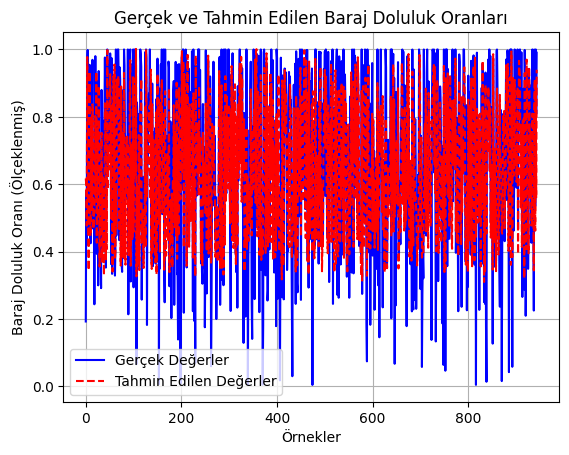

In [2]:
# FEDFORMER MODELİ
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
# Excel verilerini yükleme
data = pd.read_excel('darlıkBarajı.xlsx')
data['datetime'] = pd.to_datetime(data['datetime'])  # Tarih sütununu datetime tipine çevirin

# Verilerin ölçeklenmesi
features = ['temp', 'dew', 'humidity', 'precip',
            'windspeed', 'sealevelpressure', 'cloudcover', 'daylight_duration']
target = 'doluluk'

scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırın
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length, :-1]
        label = data[i + seq_length, -1]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

seq_length = 30  # 30 günlük geçmiş veri kullanacağız
data_array = data[features + [target]].values
X, y = create_sequences(data_array, seq_length)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# FEDformer modelini tanımlayın
class FEDformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FEDformer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Son zaman adımını alın
        out = self.fc(out)
        return out

# Model oluşturma
input_size = len(features)
hidden_size = 64
output_size = 1

model = FEDformer(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Test etme
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(output.numpy())

# Hesaplamalar
y_true = np.array(y_true)
y_pred = np.array(y_pred).flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)


epsilon = 1e-5  # Çok küçük bir değer
valid_indices = y_true > epsilon  # Sadece bu koşulu sağlayanları al
y_true_filtered = y_true[valid_indices]
y_pred_filtered = y_pred[valid_indices]

# Filtrelenmiş değerler ile MAPE hesaplaması
mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")

# Modelin tahmin yapması
def predict(data, model, scaler, seq_length):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(data[-seq_length:, :-1].reshape(1, seq_length, -1), dtype=torch.float32)
        prediction = model(inputs).item()
    return scaler.inverse_transform([[0] * (len(features)) + [prediction]])[0, -1]
    plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title('Gerçek ve Tahmin Edilen Baraj Doluluk Oranları')
plt.xlabel('Örnekler')
plt.ylabel('Baraj Doluluk Oranı (Ölçeklenmiş)')
plt.legend()
plt.grid(True)
plt.show()



Sayısal sütunlar: Index(['temp', 'dew', 'humidity', 'precip', 'windspeed', 'sealevelpressure',
       'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')


<ipython-input-3-f15710f2d584>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 1/10, Train Loss: 0.16638664121705074, Test Loss: 0.03112045567985134
Train MSE: 0.1670770452015626, Test MSE: 0.031599600181854946
Train MAPE: inf%, Test MAPE: 40.09470045566559%
Train MAE: 0.3217958778799372, Test MAE: 0.15029355758785182
Train RMSE: 0.40875059046020057, Test RMSE: 0.17776276376636066
Train R²: -1.432294922120807, Test R²: 0.025146974619128515
Training Time: 74.47912120819092 seconds, Inference Time: 4.630435466766357 seconds


<ipython-input-3-f15710f2d584>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 2/10, Train Loss: 0.13226562914335066, Test Loss: 0.03807650881629486
Train MSE: 0.1328893519588845, Test MSE: 0.03451211124775429
Train MAPE: inf%, Test MAPE: 31.771978735923767%
Train MAE: 0.25659552011078673, Test MAE: 0.15929666174273205
Train RMSE: 0.3645399181967381, Test RMSE: 0.18577435573230847
Train R²: -0.9345930829910107, Test R²: -0.06470448576984178
Training Time: 74.59208083152771 seconds, Inference Time: 3.4405903816223145 seconds


<ipython-input-3-f15710f2d584>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 3/10, Train Loss: 0.10719752090948599, Test Loss: 0.03474857885464046
Train MSE: 0.10763234697777976, Test MSE: 0.030718992335474857
Train MAPE: inf%, Test MAPE: 34.437012672424316%
Train MAE: 0.18916616223677488, Test MAE: 0.15520586399441091
Train RMSE: 0.32807369138317044, Test RMSE: 0.1752683437916695
Train R²: -0.5669035246234413, Test R²: 0.05231387604437854
Training Time: 74.69054865837097 seconds, Inference Time: 4.02721095085144 seconds


<ipython-input-3-f15710f2d584>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 4/10, Train Loss: 0.1097561155911535, Test Loss: 0.02540465072620703
Train MSE: 0.11041844360655291, Test MSE: 0.022144638455970218
Train MAPE: nan%, Test MAPE: 25.767311453819275%
Train MAE: 0.1863601974155952, Test MAE: 0.12669151590930092
Train RMSE: 0.3322927077240079, Test RMSE: 0.1488107471117937
Train R²: -0.6074633075339395, Test R²: 0.3168341475673404
Training Time: 74.08187675476074 seconds, Inference Time: 2.553351402282715 seconds


<ipython-input-3-f15710f2d584>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 5/10, Train Loss: 0.11001742130179924, Test Loss: 0.026632244231127276
Train MSE: 0.10972578659434062, Test MSE: 0.02395747658545834
Train MAPE: inf%, Test MAPE: 26.595798134803772%
Train MAE: 0.18257057644529776, Test MAE: 0.13325871389645796
Train RMSE: 0.3312488288195758, Test RMSE: 0.1547820292716772
Train R²: -0.5973796594089511, Test R²: 0.26090778378783663
Training Time: 74.59031105041504 seconds, Inference Time: 3.43743634223938 seconds


<ipython-input-3-f15710f2d584>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 6/10, Train Loss: 0.10719328625472607, Test Loss: 0.013278470800478795
Train MSE: 0.10744846913636824, Test MSE: 0.011725886546575377
Train MAPE: inf%, Test MAPE: 18.41297745704651%
Train MAE: 0.17422473350302564, Test MAE: 0.09102258931877266
Train RMSE: 0.327793332965099, Test RMSE: 0.10828613275288473
Train R²: -0.5642266449873659, Test R²: 0.6382544111502475
Training Time: 75.33605766296387 seconds, Inference Time: 3.510742664337158 seconds


<ipython-input-3-f15710f2d584>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 7/10, Train Loss: 0.10365382297890459, Test Loss: 0.014632769756166166
Train MSE: 0.10434570291098508, Test MSE: 0.01337119820974443
Train MAPE: inf%, Test MAPE: 23.51241707801819%
Train MAE: 0.1626683673424974, Test MAE: 0.10630480180948208
Train RMSE: 0.3230258548645682, Test RMSE: 0.11563389732143611
Train R²: -0.519056810164019, Test R²: 0.5874962672717121
Training Time: 76.07911348342896 seconds, Inference Time: 4.236934661865234 seconds


<ipython-input-3-f15710f2d584>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 8/10, Train Loss: 0.1058454225141624, Test Loss: 0.02331871886149441
Train MSE: 0.10650799785900915, Test MSE: 0.021767196136122574
Train MAPE: inf%, Test MAPE: 26.924356818199158%
Train MAE: 0.16288908279644412, Test MAE: 0.13163423823495196
Train RMSE: 0.32635563095955483, Test RMSE: 0.14753710088016023
Train R²: -0.5505353356302884, Test R²: 0.3284783071545726
Training Time: 76.46549224853516 seconds, Inference Time: 3.8487915992736816 seconds


<ipython-input-3-f15710f2d584>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 9/10, Train Loss: 0.1022208086624569, Test Loss: 0.018693451647107538
Train MSE: 0.10121037213572905, Test MSE: 0.01731786571854182
Train MAPE: inf%, Test MAPE: 26.878687739372253%
Train MAE: 0.15417021937573916, Test MAE: 0.12172842792466156
Train RMSE: 0.31813577625870537, Test RMSE: 0.13159736212607692
Train R²: -0.4734129030993217, Test R²: 0.46574090521074585
Training Time: 75.99025177955627 seconds, Inference Time: 2.6441495418548584 seconds


<ipython-input-3-f15710f2d584>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 10/10, Train Loss: 0.09876485055105554, Test Loss: 0.015687066540857286
Train MSE: 0.09927865539024856, Test MSE: 0.014234608797242995
Train MAPE: inf%, Test MAPE: 23.114603757858276%
Train MAE: 0.14941596249188302, Test MAE: 0.10851227895826356
Train RMSE: 0.3150851557757816, Test RMSE: 0.11930887979208837
Train R²: -0.4452911175761243, Test R²: 0.5608599041998727
Training Time: 74.41758728027344 seconds, Inference Time: 3.523082733154297 seconds


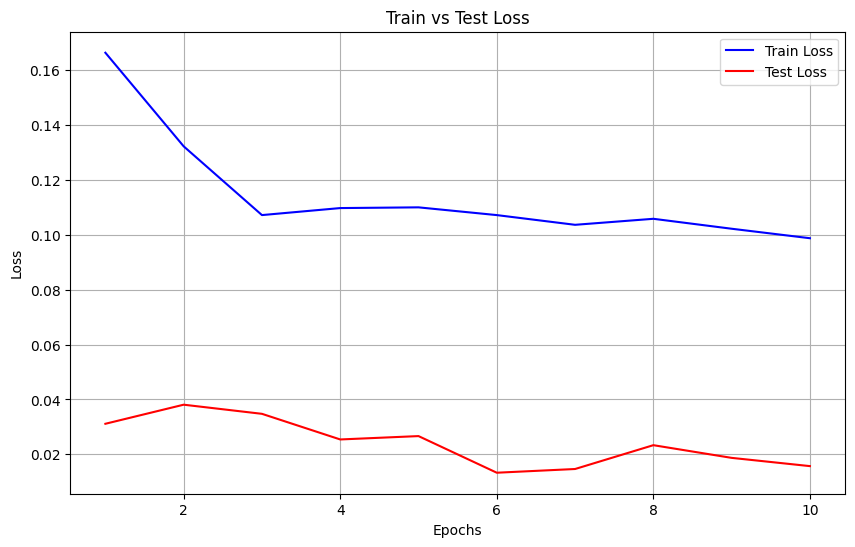

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # TFT MODELİ

# Küçük bir sabit ekleyerek sıfır bölme hatasını engelleme
epsilon = 1e-6  # Küçük bir sabit

# Veriyi yükleme
file_path = "darlıkBarajı.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "doluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("doluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):  # Yapıcı metodun doğru tanımı
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):  # Veri setinin uzunluğunu döner
        return len(self.X)

    def __getitem__(self, index):  # Belirtilen indeks için X ve y değerlerini döner
        return self.X[index], self.y[index]

# Dataset ve DataLoader oluşturma
train_dataset = TimeSeriesDataset(X_train, y_train)  # Burada hata alınmamalı
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Düzeltildi
        super(TemporalFusionTransformer, self).__init__()
        # LSTM katmanı (geleneksel zaman serisi öğrenme)
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # TFT'nin temel bileşenlerinden olan konvasyonel katmanlar
        self.attn_layer = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Diğer TFT katmanları (eklenebilir)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # LSTM katmanı çıkışı
        lstm_out, _ = self.lstm(x)

        # Multihead Attention katmanı (geleneksel zaman serisi için)
        attn_out, _ = self.attn_layer(lstm_out, lstm_out, lstm_out)

        # TFT modelindeki tam bağlı katman
        output = self.fc(attn_out[:, -1, :])  # Sadece son zaman dilimindeki tahmin
        output = self.dropout(output)
        return output


# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64  # LSTM katmanının gizli boyutu
output_dim = 1  # Baraj doluluk yüzdesi

# Modeli oluşturma
model = TemporalFusionTransformer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()  # Kayıp fonksiyonu (Mean Squared Error)
optimizer = Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 10  # Eğitim süresini artırdım
train_losses = []
test_losses = []

# Eğitim ve çıkarım sürelerini kaydetmek için listeler
train_times = []
inference_times = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    start_train = time.time()  # Eğitim zamanı başlat
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())
    end_train = time.time()  # Eğitim zamanı bitir
    train_times.append(end_train - start_train)  # Eğitim süresini kaydet

    train_losses.append(train_loss / len(train_loader))

    # Eğitim metriklerini hesapla
    train_mse = mean_squared_error(train_actuals, train_preds)
    train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
    train_mae = mean_absolute_error(train_actuals, train_preds)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(train_actuals, train_preds)

    # Test değerlendirme
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    start_inference = time.time()  # Çıkarım zamanı başlat
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())
    end_inference = time.time()  # Çıkarım zamanı bitir
    inference_times.append(end_inference - start_inference)  # Çıkarım süresini kaydet

    test_losses.append(test_loss / len(test_loader))

    test_mse = mean_squared_error(test_actuals, test_preds)
    test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100
    test_mae = mean_absolute_error(test_actuals, test_preds)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_actuals, test_preds)

    # Sonuçları yazdırma
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train MAPE: {train_mape}%, Test MAPE: {test_mape}%")
    print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train R²: {train_r2}, Test R²: {test_r2}")
    print(f"Training Time: {train_times[-1]} seconds, Inference Time: {inference_times[-1]} seconds")

# Gerçek ve tahmin edilen değerleri birleştirip Excel dosyasına kaydetme (Eğitim ve çıkarım süreleri hariç)
result_df = pd.DataFrame({
    'Gerçek Değerler': test_actuals,
    'Tahminler': test_preds
})

# Excel dosyasına kaydetme
result_df.to_excel("baraj_doluluk_tahminleri.xlsx", index=False)

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.0978
Epoch 2/50, Loss: 0.0544
Epoch 3/50, Loss: 0.0475
Epoch 4/50, Loss: 0.0450
Epoch 5/50, Loss: 0.0441
Epoch 6/50, Loss: 0.0431
Epoch 7/50, Loss: 0.0420
Epoch 8/50, Loss: 0.0419
Epoch 9/50, Loss: 0.0412
Epoch 10/50, Loss: 0.0412
Epoch 11/50, Loss: 0.0406
Epoch 12/50, Loss: 0.0408
Epoch 13/50, Loss: 0.0402
Epoch 14/50, Loss: 0.0400
Epoch 15/50, Loss: 0.0400
Epoch 16/50, Loss: 0.0394
Epoch 17/50, Loss: 0.0391
Epoch 18/50, Loss: 0.0390
Epoch 19/50, Loss: 0.0389
Epoch 20/50, Loss: 0.0393
Epoch 21/50, Loss: 0.0392
Epoch 22/50, Loss: 0.0393
Epoch 23/50, Loss: 0.0391
Epoch 24/50, Loss: 0.0386
Epoch 25/50, Loss: 0.0381
Epoch 26/50, Loss: 0.0388
Epoch 27/50, Loss: 0.0380
Epoch 28/50, Loss: 0.0385
Epoch 29/50, Loss: 0.0382
Epoch 30/50, Loss: 0.0378
Epoch 31/50, Loss: 0.0376
Epoch 32/50, Loss: 0.0380
Epoch 33/50, Loss: 0.0379
Epoch 34/50, Loss: 0.0379
Epoch 35/50, Loss: 0.0376
Epoch 36/50, Loss: 0.0388
Epoch 37/50, Loss: 0.0375
Epoch 38/50, Loss: 0.0376
Epoch 39/50, Loss: 0.

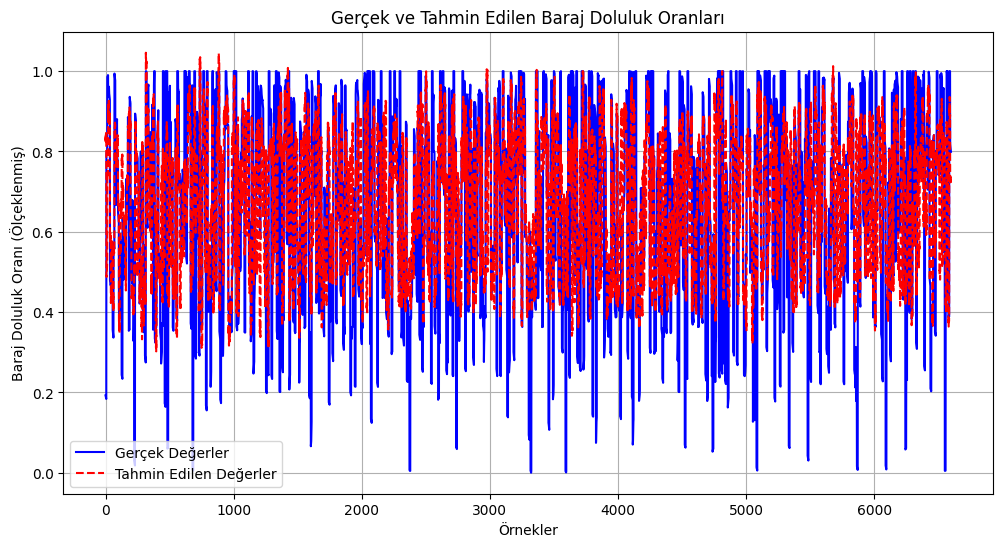

In [4]:
# İNFORMER
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

data = pd.read_excel('darlıkBarajı.xlsx')
data['datetime'] = pd.to_datetime(data['datetime'])  # Tarih sütununu datetime tipine çevirin

# Verilerin ölçeklenmesi
features = ['temp', 'dew', 'humidity', 'precip',
            'windspeed', 'sealevelpressure', 'cloudcover', 'daylight_duration']
target = 'doluluk'


scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırma
def create_sequences(data, input_len, pred_len):
    X, y = [], []
    for i in range(len(data) - input_len - pred_len):
        X.append(data[i:i + input_len, :-1])
        y.append(data[i + input_len:i + input_len + pred_len, -1])
    return np.array(X), np.array(y)

input_len = 30  # Geçmiş 30 gün
pred_len = 7    # Tahmin edilen 7 gün
data_array = data[features + [target]].values
X, y = create_sequences(data_array, input_len, pred_len)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Informer modeli
class Informer(nn.Module):
    def __init__(self, input_size, seq_len, pred_len, d_model, num_heads, num_layers):
        super(Informer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(seq_len * input_size, pred_len)

    def forward(self, x):
        batch_size, seq_len, input_size = x.size()
        x = x.view(batch_size, seq_len * input_size)  # Flatten for linear layer
        x = self.fc(x)
        return x

# Model oluşturma
input_size = len(features)
d_model = 64
num_heads = 4
num_layers = 2

model = Informer(input_size, seq_len=input_len, pred_len=pred_len,
                 d_model=d_model, num_heads=num_heads, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Test etme
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy().flatten())
        y_pred.extend(output.numpy().flatten())

# Performans metrikleri
# Performans metrikleri
y_true = np.array(y_true)
y_pred = np.array(y_pred)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")

# Tahmin ve görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title('Gerçek ve Tahmin Edilen Baraj Doluluk Oranları')
plt.xlabel('Örnekler')
plt.ylabel('Baraj Doluluk Oranı (Ölçeklenmiş)')
plt.legend()
plt.grid(True)
plt.show()


Sayısal sütunlar: Index(['temp', 'dew', 'humidity', 'precip', 'windspeed', 'sealevelpressure',
       'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')


<ipython-input-5-5dbcdda173cc>:129: RuntimeWarning: divide by zero encountered in divide
  train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)


Epoch 1/3, Train Loss: 0.06810576630394077, Test Loss: 0.006170396735174826
Train MSE: 0.06854858909476352, Test MSE: 0.006283457638965222
Train MAPE: inf%, Test MAPE: 18.87236088514328%
Train MAE: 0.18569699111395263, Test MAE: 0.06877340758458161
Train RMSE: 0.2618178548051365, Test RMSE: 0.07926826375646953
Train R²: 0.0020748513202718533, Test R²: 0.8061542660683683
Training time for epoch 1: 69.55 seconds
Inference time for epoch 1: 0.61 seconds


<ipython-input-5-5dbcdda173cc>:129: RuntimeWarning: divide by zero encountered in divide
  train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)


Epoch 2/3, Train Loss: 0.0020474453706777205, Test Loss: 0.001449031027732417
Train MSE: 0.002058424457840692, Test MSE: 0.0014051540129157263
Train MAPE: inf%, Test MAPE: 6.768855452537537%
Train MAE: 0.03372103502094814, Test MAE: 0.026751611426345304
Train RMSE: 0.04536986288099946, Test RMSE: 0.03748538399050657
Train R²: 0.970033613233134, Test R²: 0.9566507603661536
Training time for epoch 2: 18.17 seconds
Inference time for epoch 2: 0.79 seconds


<ipython-input-5-5dbcdda173cc>:129: RuntimeWarning: divide by zero encountered in divide
  train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)


Epoch 3/3, Train Loss: 0.0006698562463969682, Test Loss: 0.0005095186547566156
Train MSE: 0.0006721515572364981, Test MSE: 0.0005236845226677233
Train MAPE: inf%, Test MAPE: 4.317153617739677%
Train MAE: 0.01835047369499352, Test MAE: 0.016520322235221537
Train RMSE: 0.025925885852493027, Test RMSE: 0.022884154401413292
Train R²: 0.9902148687296354, Test R²: 0.9838442436508765
Training time for epoch 3: 18.42 seconds
Inference time for epoch 3: 0.61 seconds


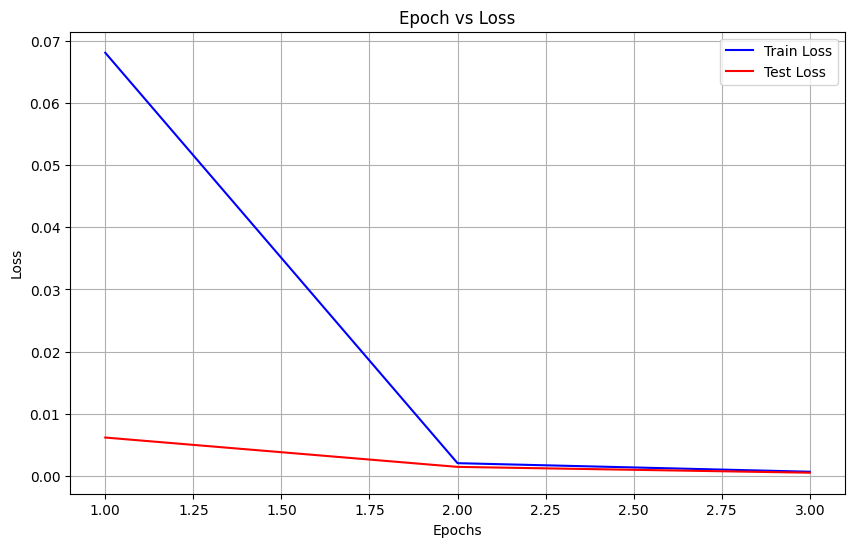

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ETSFORMER yükleme
file_path = "darlıkBarajı.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)  # Hangi sütunların seçildiğini kontrol edebilirsiniz

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "doluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("doluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):  # Doğru yazım: __init__
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):  # Doğru yazım: __len__
        return len(self.X)

    def __getitem__(self, index):  # Doğru yazım: __getitem__
        return self.X[index], self.y[index]

# Dataset ve DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Basit bir ETSFormer modeli (örnek olarak LSTM temelli)
class SimpleETSFormer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Doğru yazım: __init__
        super(SimpleETSFormer, self).__init__()  # Doğru yazım: __init__
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output


# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64
output_dim = 1  # Baraj doluluk yüzdesi

model = SimpleETSFormer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Eğitim ve test kayıplarını saklamak için listeler
train_losses = []
test_losses = []

# Eğitim ve test metriklerini saklamak için listeler
train_mse, train_mape, train_mae, train_rmse, train_r2 = [], [], [], [], []
test_mse, test_mape, test_mae, test_rmse, test_r2 = [], [], [], [], []

# Model eğitimi ve değerlendirme
epochs = 3
for epoch in range(epochs):
    start_train_time = time.time()  # Eğitim başlangıç zamanı
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())

    # Eğitim süresi
    train_time = time.time() - start_train_time

    # Eğitim metriklerini hesapla
    train_mse.append(mean_squared_error(train_actuals, train_preds))
    train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)
    train_mae.append(mean_absolute_error(train_actuals, train_preds))
    train_rmse.append(np.sqrt(mean_squared_error(train_actuals, train_preds)))
    train_r2.append(r2_score(train_actuals, train_preds))

    # Eğitim kaybını kaydetme
    train_losses.append(train_loss / len(train_loader))

    # Test değerlendirme
    start_test_time = time.time()  # Test başlangıç zamanı
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())

    # Test süresi
    test_time = time.time() - start_test_time

    # Test metriklerini hesapla
    test_mse.append(mean_squared_error(test_actuals, test_preds))
    test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)
    test_mae.append(mean_absolute_error(test_actuals, test_preds))
    test_rmse.append(np.sqrt(mean_squared_error(test_actuals, test_preds)))
    test_r2.append(r2_score(test_actuals, test_preds))

    # Test kaybını kaydetme
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse[-1]}, Test MSE: {test_mse[-1]}")
    print(f"Train MAPE: {train_mape[-1]}%, Test MAPE: {test_mape[-1]}%")
    print(f"Train MAE: {train_mae[-1]}, Test MAE: {test_mae[-1]}")
    print(f"Train RMSE: {train_rmse[-1]}, Test RMSE: {test_rmse[-1]}")
    print(f"Train R²: {train_r2[-1]}, Test R²: {test_r2[-1]}")
    print(f"Training time for epoch {epoch+1}: {train_time:.2f} seconds")
    print(f"Inference time for epoch {epoch+1}: {test_time:.2f} seconds")

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

Index(['datetime', 'temp', 'dew', 'humidity', 'precip', 'windspeed',
       'sealevelpressure', 'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')
            temp  dew  humidity  precip  windspeed  sealevelpressure  \
datetime                                                               
2011-01-01   3.2 -0.6      77.1   0.000       12.7            1020.4   
2011-01-02   6.2 -0.9      61.3   0.000       17.9            1016.0   
2011-01-03   6.3  3.1      80.6   0.612       19.1            1011.8   
2011-01-04   5.1  3.1      87.5   1.550       30.1            1018.6   
2011-01-05   4.7  0.5      74.4   0.000       27.7            1023.3   

            cloudcover  daylight_duration  doluluk  weighted_score  
datetime                                                            
2011-01-01         9.3         556.216667    84.86        178.8460  
2011-01-02        34.0         556.966667    85.02        179.5960  
2011-01-03        87.4         557.766667    85.07    

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                doluluk   No. Observations:                 3323
Model:                ARIMA(10, 1, 5)   Log Likelihood               -1958.246
Date:                Fri, 03 Jan 2025   AIC                           3948.492
Time:                        05:52:53   BIC                           4046.225
Sample:                    01-01-2011   HQIC                          3983.465
                         - 02-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5555      0.226      2.461      0.014       0.113       0.998
ar.L2          0.0683      0.294      0.233      0.816      -0.507       0.644
ar.L3          0.0055      0.223      0.025      0.9

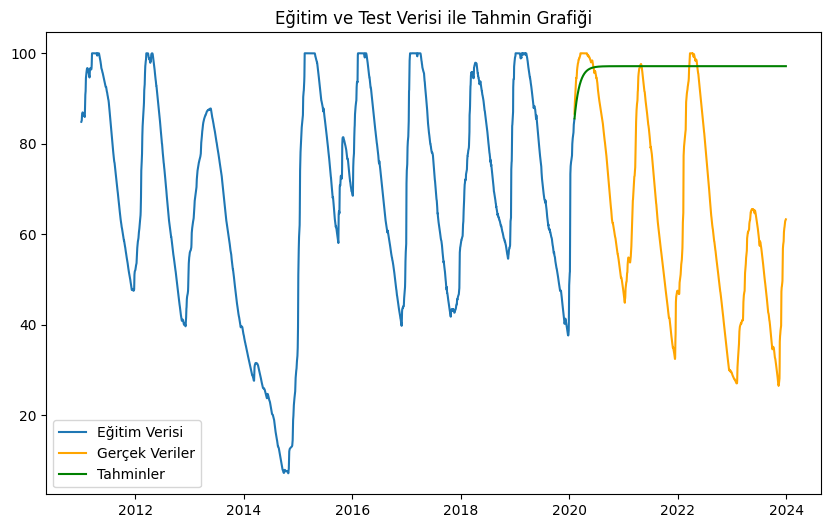

Mean Squared Error (MSE): 1549.621860406936
Root Mean Squared Error (RMSE): 39.36523669949079
Mean Absolute Error (MAE): 32.84756253759717
Mean Absolute Percentage Error (MAPE): 0.7244878233069723%
R²: -2.0397190281340554
Eğitim Süreti: 20.286484956741333 saniye
Çıkarım Süreti: 0.04609513282775879 saniye


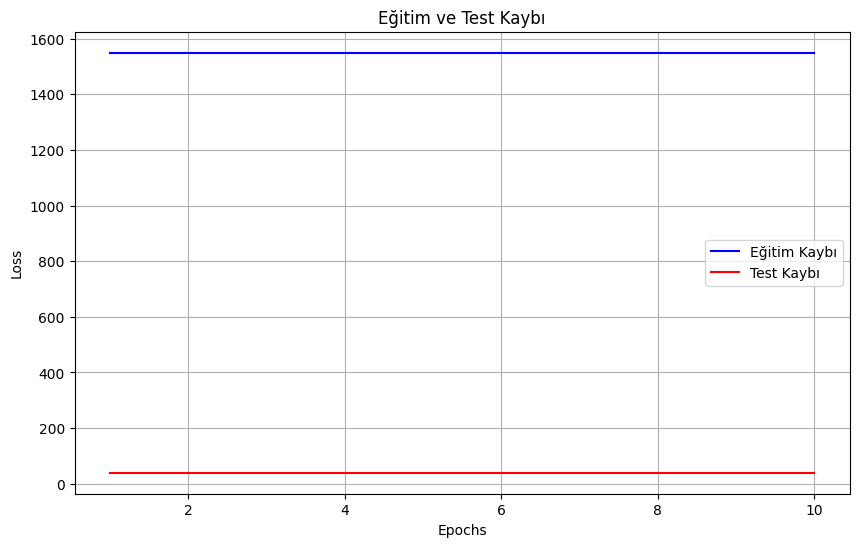

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import time

# ARIMA MODELLEMESI
df = pd.read_excel('darlıkBarajı.xlsx')
print(df.columns)

# Tarih sütununu datetime formatına çevirin
df['datetime'] = pd.to_datetime(df['datetime'])

# Veriyi tarihe göre sıralama
df = df.sort_values(by='datetime')

# Ağırlıkları belirleyin
weights = {
    'temp': 0.4,

    'dew': 0.05,
    'humidity': 0.1,
    'precip': 0.7,
    'windspeed': 0.05,
    'sealevelpressure': 0.1,
    'cloudcover': 0.05,
    'daylight_duration': 0.12
}

# Baraj doluluk yüzdesi ve diğer bağımsız değişkenler
df = df[['datetime', 'temp', 'dew', 'humidity', 'precip',
       'windspeed', 'sealevelpressure', 'cloudcover', 'daylight_duration',
       'doluluk']]

# Ağırlıklı skor hesaplama
df['weighted_score'] = (weights['temp'] * df['temp'] +

                        weights['dew'] * df['dew'] +
                        weights['humidity'] * df['humidity'] +
                        weights['precip'] * df['precip'] +
                        weights['windspeed'] * df['windspeed'] +
                        weights['sealevelpressure'] * df['sealevelpressure'] +
                        weights['cloudcover'] * df['cloudcover'] +
                        weights['daylight_duration'] * df['daylight_duration'])

# Tarihi indeks olarak ayarlayın
df.set_index('datetime', inplace=True)

# Veriye göz atın
print(df.head())

# Baraj doluluk yüzdesi kolonunu hedef olarak seçin
y = df['doluluk']

# Veriyi eğitim ve test setlerine ayırın (shuffle=False)
train, test = train_test_split(y, test_size=0.3, shuffle=False)

# Eğitim ve test zamanlaması
start_time = time.time()  # Eğitim zamanını başlatma

# ARIMA modelini tanımlayın
model = ARIMA(train, order=(10,1,5)) #2 yıla göre tahmin eder 1 fark ile q=2 ise geçmiş hatalarla ilgilenmedir

# Modeli eğitin
model_fit = model.fit()

# Eğitim süreti
end_time = time.time()
training_time = end_time - start_time  # Eğitim süreti hesaplama

# Modelin özetine göz atın
print(model_fit.summary())

# Test verisi üzerinde tahmin yapın
start_inference_time = time.time()  # Çıkarım (inference) zamanını başlatma
predictions = model_fit.forecast(steps=len(test))
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time  # Çıkarım süreti

# Tahminleri görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Eğitim Verisi')
plt.plot(test.index, test, label='Gerçek Veriler', color='orange')
plt.plot(test.index, predictions, label='Tahminler', color='green')
plt.legend()
plt.title('Eğitim ve Test Verisi ile Tahmin Grafiği')
plt.show()

# Modelin başarımını değerlendirelim
mse = mean_squared_error(test, predictions)
mse_rmse = np.sqrt(mse)  # RMSE
mae = mean_absolute_error(test, predictions)  # MAE
mape = mean_absolute_percentage_error(test, predictions)  # MAPE
r2 = r2_score(test, predictions)  # R²

# Sonuçları yazdırma
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {mse_rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R²: {r2}')
print(f'Eğitim Süreti: {training_time} saniye')
print(f'Çıkarım Süreti: {inference_time} saniye')

# Sonuçları Excel dosyasına kaydetme
result_df = pd.DataFrame({
    'Gerçek Değerler': test,
    'Tahminler': predictions
})

result_df.to_excel("baraj_doluluk_tahminleri.xlsx", index=True)

# Kaybın (Loss) Grafiği
epochs = 10
train_losses = [mse] * epochs
test_losses = [mse_rmse] * epochs

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Eğitim Kaybı", color='blue')
plt.plot(range(1, epochs + 1), test_losses, label="Test Kaybı", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Eğitim ve Test Kaybı")
plt.legend()
plt.grid(True)
plt.show()